## Compare my analytical code and Zeljko's , flat prior 

Here I read in Zeljko's calculation , and on the same grid of xObs I calculate my own Mean,  Rms, using the analytical calculation 
This is done only for a flat prior 

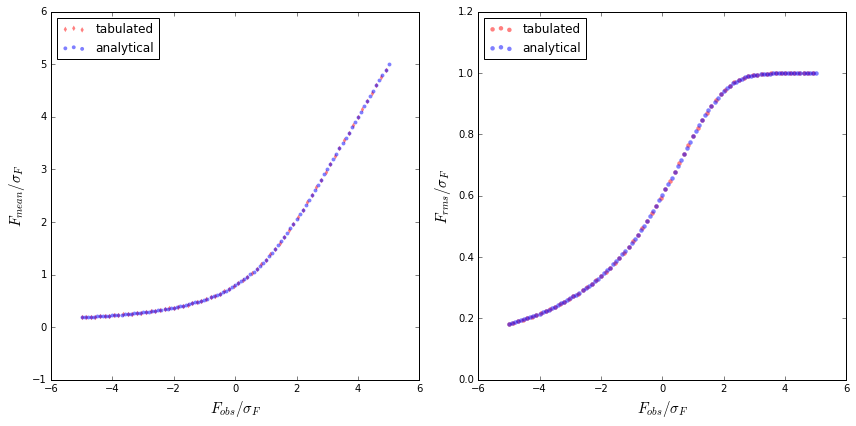

In [1]:
import numpy as np
import scipy.special as sp
from scipy.stats import norm
from scipy.special import erfc
import matplotlib.pyplot as plt 
import sys
sys.path.insert(0, '/astro/users/suberlak/S13Agg_analysis/packages/')
import faintFunctions as faintF 

%matplotlib inline

# Compare Zeljko's calculation with mine... 
data = np.genfromtxt('posteriorF.dat', comments='#')
xObs , expF , rmsF = data[:,0], data[:,1], data[:,2]

# mock sigma to use my varF 
sigma = 0.01
fObs= xObs * sigma
sigObs = np.ones_like(fObs) * sigma

fMean = faintF.calculate_mean(fObs, sigObs)
xMean = fMean / sigma
#xMean = (np.exp(-(xObs**2.0) / 2.0) / (norm.sf(-xObs )*np.sqrt(2*np.pi))) + xObs

#delX = xObs - xMean
#I1 = norm.sf(-xObs)
#I0bysig2 = 0.5*sp.erf(xObs/np.sqrt(2)) + (1.0/np.sqrt(2*np.pi))*np.exp(-(xObs**2.0) / 2.0)*(2*delX - xObs) + 0.5 + delX*delX*norm.sf(-xObs)
#(1.0/np.sqrt(2*np.pi))*((np.sqrt(2*np.pi) + delX**2.0 )*norm.sf(-xObs)  - 2*xMean*np.exp(-(xObs**2.0) / 2.0))
#xRms = np.sqrt(I0bysig2 / I1) 
fRms= faintF.calculate_rms(fObs, sigObs)
xRms = fRms/ sigma

fig,ax = plt.subplots(1,2, figsize=(12,6))
size=15
ax[0].scatter(xObs[::15], expF[::15] , lw=0, s=size ,alpha=0.5, color='red', marker = 'd',label='tabulated' )
ax[0].scatter(xObs[::10] , xMean[::10], lw=0, s=size, alpha=0.5, color='b',label='analytical')
ax[0].set_xlabel(r'$F_{obs} / \sigma_{F}$', fontsize=15)
ax[0].set_ylabel(r'$F_{mean}/ \sigma_{F}$', fontsize=15)
ax[0].legend(loc='upper left')
ax[1].scatter(xObs[::15], np.sqrt(rmsF[::15]), lw=0, alpha=0.5, color='red',label='tabulated')
ax[1].scatter(xObs[::10], xRms[::10], lw=0, alpha=0.5, color='blue',label='analytical')
ax[1].set_xlabel(r'$ F_{obs} / \sigma_{F}$', fontsize=15)
ax[1].set_ylabel(r'$ F_{rms} / \sigma_{F}$', fontsize=15)
ax[1].legend(loc='upper left')
plt.tight_layout()
plt.savefig('F_obs_F_mean_scaled.png')

## Direct integration, for flat and Euclidean priors 

In [2]:
## Calculate the mean, rms , 2 sigma level  in a direct way (by direct integration over x-grid), 
## like Zeljko did in SM, that was the result of the table in posteriorF.dat 

import numpy as np
import matplotlib.pyplot as plt 

x = np.arange(0.01,15,0.001)  # true x : integration grid 
xOBS = np.linspace(-5,10, 1000) # F_obs / sigmaF
xM = []
xRMS = []
xM_euc = []
xRMS_euc = []
x2SIG = []
x2SIG_euc = []

for x_obs in xOBS : 
    # integrate over x, 0 to 10 sufficient since exp(-100) ~ 0 
    
    # Gaussian likelihood and flat prior
    # x_mean  = F_mean / sigmaF
    f0 = np.exp(-((x-x_obs)**2.0) / 2.0)  # normalization
    f1 = x*np.exp(-((x-x_obs)**2.0) / 2.0)  # mean
    x_mean = np.sum(f1) / np.sum(f0)
    xM.append(x_mean)
    # x_rms = root-mean-square / sigmaF

    g0 = f0
    g1 = ((x-x_mean)**(2.0)) * f0

    x_rms =np.sqrt(np.sum(g1) / np.sum(g0))
    xRMS.append(x_rms)  # this is the square of the rms, to compare with Z's calculation
    
    lhs = []
    rhs = 0.05 * np.sum(f0)

    for i in range(len(x)):
        sum_i = np.sum(f0[i:])
        lhs.append(sum_i)

    abs_diff = np.abs(lhs-rhs)
    lhs_arr = np.array(lhs)
    msk = abs_diff == np.min(abs_diff)
    x_2sig = x[msk][0]
    
    x2SIG.append(x_2sig)
    

    
    # Gaussian likelihood and Euclidean prior 
    # x_mean  = F_mean / sigmaF
    f0 = x**(-1.5)*np.exp(-((x-x_obs)**2.0) / 2.0)  # normalization
    f1 = x**(-1.5)*x*np.exp(-((x-x_obs)**2.0) / 2.0)  # mean
    x_mean = np.sum(f1) / np.sum(f0)
    xM_euc.append(x_mean)
    # x_rms = root-mean-square / sigmaF

    g0 = f0
    g1 = ((x-x_mean)**(2.0)) * f0

    x_rms =np.sqrt(np.sum(g1) / np.sum(g0))
    xRMS_euc.append(x_rms)  # this is the square of the rms, to compare with Z's calculation
    
    # x_2sig   is where the integral from x_2sig to inf  is 0.05 of the integral from 
    # 0 to infty (i.e. over the entire normalized range)
    # no need to normalize because both sums (lhs and rhs ) would be divided by the same integral 
    lhs = []
    rhs = 0.05 * np.sum(f0)

    for i in range(len(x)):
        sum_i = np.sum(f0[i:])
        lhs.append(sum_i)

    abs_diff = np.abs(lhs-rhs)
    lhs_arr = np.array(lhs)
    msk = abs_diff == np.min(abs_diff)
    x_2sig = x[msk][0]
    
    x2SIG_euc.append(x_2sig)
    

In [40]:
# since this calculation takes some time (about 5 mins on the workstation 
# on the grid of   x = np.arange(0.01,15,0.001)  and xOBS = np.linspace(-5,10, 1000)
# save the results so that they can be used again


data = np.column_stack((xOBS, xM_euc, xRMS_euc, x2SIG_euc))
np.savetxt('/astro/users/suberlak/S13Agg_analysis/data_products/'+'Fig3_xObs_xMean_xRms_x2Sig_euc_prior.txt', data )

data = np.column_stack((xOBS, xM, xRMS, x2SIG))
np.savetxt('/astro/users/suberlak/S13Agg_analysis/data_products/'+'Fig3_xObs_xMean_xRms_x2Sig_flat_prior.txt', data )





In [27]:
# Calculate on the same grid the analytical results (which can only do flat prior...)
# this is because there is no simple analytical form for integrating 
# int_{x_min}^{inf} {x**(-1.5)*x*np.exp(-((x-x_obs)**2.0) / 2.0) } and the like 
# which are required by the Euclidean approach 

# choose some arbitrary sigma 
sigma = 0.01
fOBS = xOBS * sigma  # fOBS array 
sigOBS = np.ones_like(fOBS) * sigma  # fOBS error array 

xM_an = faintF.calculate_mean(fOBS, sigOBS) / sigma
xRMS_an = faintF.calculate_rms(fOBS, sigOBS)/ sigma
x2SIG_an = faintF.calculate_2sigma(fOBS, sigOBS)/ sigma




# Plot the results of direct integration 

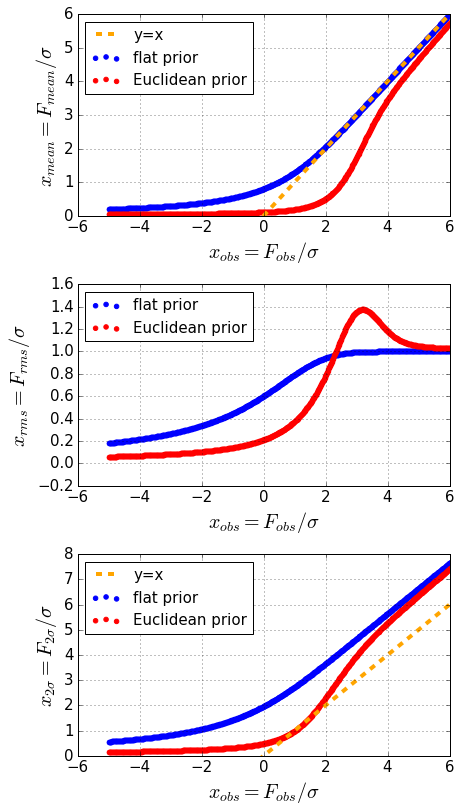

In [38]:
%matplotlib inline

import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(6.5,11.4))
gs = gridspec.GridSpec(3,2)  # (nrows, ncols)
ax = dict()
ax[0] = plt.subplot(gs[0, :])  # upper row, both cols
ax[1] = plt.subplot(gs[1, :])  # middle row, both cols
ax[2] = plt.subplot(gs[2, :])  # bottom row, both cols


#fig,ax = plt.subplots(1,2, figsize=(13,3.8))



# plot the mean 
ax[0].plot(xOBS, xOBS, ls='--', color='orange', lw=4,label='y=x')
ax[0].scatter(xOBS, xM, color='blue', label='flat prior')
ax[0].scatter(xOBS, xM_euc, color='red', label='Euclidean prior')
#ax[0].scatter(xOBS, xM_an, color='green')
ax[0].set_xlabel(r'$x_{obs} = F_{obs} / \sigma$', fontsize=20)
ax[0].set_ylabel(r'$x_{mean}= F_{mean} / \sigma$', fontsize=20)


# plot the rms 
ax[1].scatter(xOBS, xRMS, color='blue', label='flat prior')
ax[1].scatter(xOBS,xRMS_euc, color='red',label='Euclidean prior')
#ax[1].scatter(xOBS,xRMS_an, color='green')
ax[1].set_xlabel(r'$x_{obs} = F_{obs} / \sigma$', fontsize=20)
ax[1].set_ylabel(r'$x_{rms}= F_{rms} / \sigma$', fontsize=20)

# plot the 2 sigma level
ax[2].plot(xOBS, xOBS, ls='--', color='orange', lw=4, label='y=x')
ax[2].scatter(xOBS, x2SIG, color='blue', label='flat prior')
ax[2].scatter(xOBS, x2SIG_euc, color='red',label='Euclidean prior')
#ax[2].scatter(xOBS,x2SIG_an, color='green')
ax[2].set_xlabel(r'$x_{obs} = F_{obs} / \sigma$', fontsize=20)
ax[2].set_ylabel(r'$x_{2\sigma}= F_{2\sigma} / \sigma$', fontsize=20)


for i in range(3): 
    ax[i].tick_params(axis='both', which='major', labelsize=15)
    ax[i].grid()
    ax[i].legend(loc='upper left', fontsize=15)
    ax[i].set_xlim(-6,6)


ax[0].set_ylim(0,6)
ax[2].set_ylim(0,8)



fig.subplots_adjust(wspace=0.3,)
plt.tight_layout()
plt.savefig('/astro/users/suberlak/S13Agg_analysis/data_products/'+'Fig3_direct_integration_priors.png')

## Compare direct and analytical with flat prior (same result )

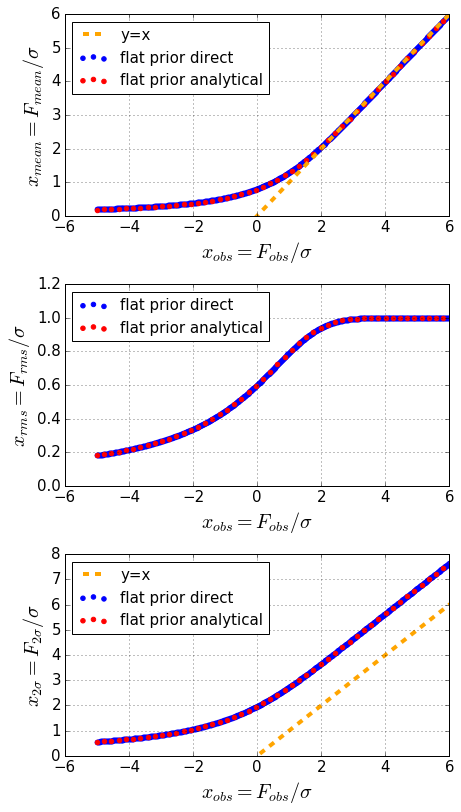

In [37]:
# to validate that direct integration and analytical integration 
# methods work in principle (for flat prior)
# plot the results 

%matplotlib inline

import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(6.5,11.4))
gs = gridspec.GridSpec(3,2)  # (nrows, ncols)
ax = dict()
ax[0] = plt.subplot(gs[0, :])  # upper row, both cols
ax[1] = plt.subplot(gs[1, :])  # middle row, both cols
ax[2] = plt.subplot(gs[2, :])  # bottom row, both cols


#fig,ax = plt.subplots(1,2, figsize=(13,3.8))
# plot the mean 
ax[0].plot(xOBS, xOBS, ls='--', color='orange', lw=4,label='y=x')
ax[0].scatter(xOBS, xM ,color='blue', label='flat prior direct')
ax[0].scatter(xOBS[::15], xM_an[::15], color='red',label='flat prior analytical' )
ax[0].set_xlabel(r'$x_{obs} = F_{obs} / \sigma$', fontsize=20)
ax[0].set_ylabel(r'$x_{mean}= F_{mean} / \sigma$', fontsize=20)


# plot the rms 
ax[1].scatter(xOBS, xRMS, color='blue', label='flat prior direct')
ax[1].scatter(xOBS[::15],xRMS_an[::15], color='red',label='flat prior analytical' )
ax[1].set_xlabel(r'$x_{obs} = F_{obs} / \sigma$', fontsize=20)
ax[1].set_ylabel(r'$x_{rms}= F_{rms} / \sigma$', fontsize=20)

# plot the 2 sigma level
ax[2].plot(xOBS, xOBS, ls='--', color='orange', lw=4, label='y=x')
ax[2].scatter(xOBS, x2SIG, color='blue', label='flat prior direct')
ax[2].scatter(xOBS[::15],x2SIG_an[::15], color='red',label='flat prior analytical' )
ax[2].set_xlabel(r'$x_{obs} = F_{obs} / \sigma$', fontsize=20)
ax[2].set_ylabel(r'$x_{2\sigma}= F_{2\sigma} / \sigma$', fontsize=20)


for i in range(3): 
    ax[i].tick_params(axis='both', which='major', labelsize=15)
    ax[i].grid()
    ax[i].legend(loc='upper left', fontsize=15)
    ax[i].set_xlim(-6,6)


ax[0].set_ylim(0,6)
ax[2].set_ylim(0,8)



fig.subplots_adjust(wspace=0.3,)
plt.tight_layout()
plt.savefig('/astro/users/suberlak/S13Agg_analysis/data_products/'+'Fig3_flat_prior_analytical_direct_comp.png')